In [11]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from sklearn.mixture import GaussianMixture
from hough_circle_trafo import hough_circle
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import ndimage
from background_subtraction_gmm import Backsub as Backsub
from sklearn.cluster import KMeans
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from segmentation import Segmentation as Segmentation
from PIL import Image, ImageDraw
import networkx as nx
from networkx.algorithms import bipartite
from scipy.stats import norm
np.random.seed(137)

In [12]:
start_frame=0
end_frame=987
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
obj_0=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
obj_0=obj_0[1:,:]

frame_number=97
im=cv.imread(cv.samples.findFile(stream_string[frame_number]), cv.IMREAD_GRAYSCALE)
obj=obj_0[frame_number,1:]
x=obj[0]
y=obj[1]
r=obj[2]
a=10
object_indeces=np.s_[-a+round(y-round(r)):round(y+round(r))+1+a,
                     -a+round(x-round(r)):round(x+round(r))+1+a]
im_obj=im[object_indeces]

In [13]:
koppenrath=Confectionery()
blue_vector=np.array([0,0,255],dtype=np.uint8).reshape((1,1,3))
green_vector=np.array([0,128,0],dtype=np.uint8).reshape((1,1,3))
cyan_vector=np.array([0,255,255],dtype=np.uint8).reshape((1,1,3))
red_vector=np.array([255,0,0]).reshape((1,1,3))



In [14]:
r_effective=11
M=koppenrath.sell_cake(r_effective,im_obj.shape[0],im_obj.shape[1])
cluster=Half_shelf_cluster(obj_0, stream_string, confectionery=koppenrath,cut_radius=r_effective)
cluster.load_data_from_np_array(np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0_all_grayscale_on_radius_11.npy"))
data=im_obj[M==1].reshape(-1)
label=cluster.label(data,method="GMM")
label=label+1

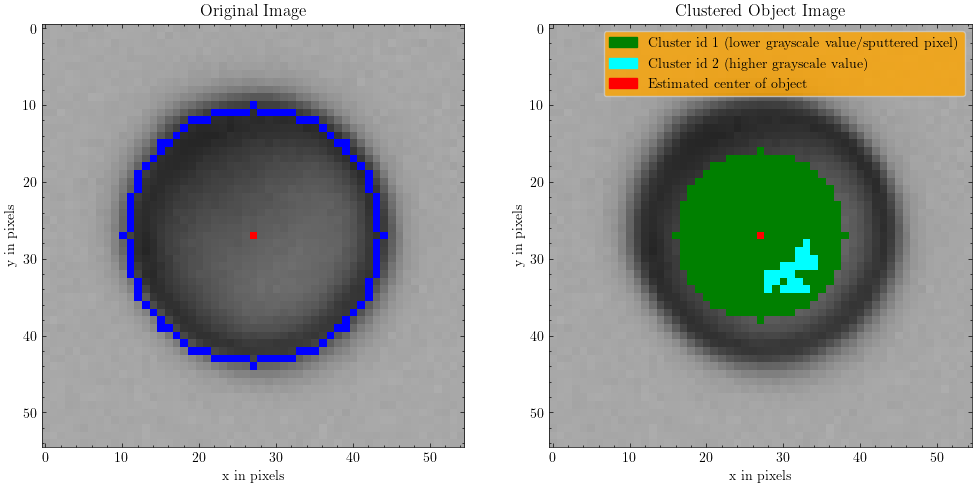

In [15]:
im_clustered=np.zeros(im_obj.shape,np.uint8)
im_clustered[M==1]=label
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)

im_clustered=np.copy(cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR))
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=green_vector
b=np.arange(a1.size)
c=b[a2]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=cyan_vector
im_clustered[(im_clustered.shape[0]-1)//2,(im_clustered.shape[0]-1)//2,:]=red_vector

im_bgr=cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR)
center=((im_bgr.shape[0]-1)//2, (im_bgr.shape[0]-1)//2)
im_bgr[center[0],center[0],:]=np.array([255,0,0])
cv.circle(im_bgr, center, round(r), (0,0,255), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Original Image")
    ax1.imshow(im_bgr,cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    ax2.imshow(im_clustered)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax2.legend(handles=[green_patch, cyan_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()

# get probabilities of prediction

In [16]:
gmm=cluster.gmm
prob=gmm.predict_proba(data.reshape((-1,1)))

prob=prob[:,cluster.gmm_idx]

p_thresh=0.85
label_thresh=prob>=p_thresh
label_thresh=np.array([0 if x[0]==1 else 1 if x[1]==1 else 2 for x in label_thresh])
label_thresh=label_thresh+1

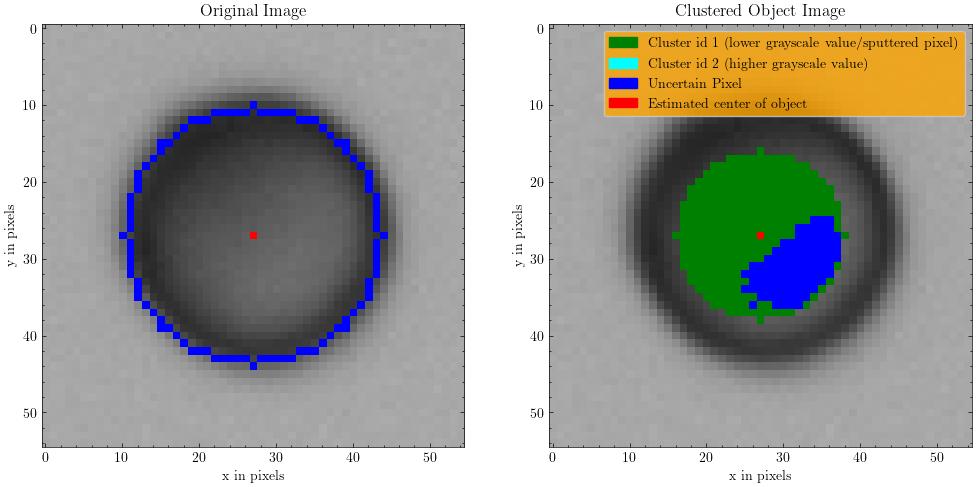

In [17]:
im_clustered=np.zeros(im_obj.shape,np.uint8)
im_clustered[M==1]=label_thresh
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)
a3=(im_clustered==3).reshape(-1)

im_clustered=np.copy(cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR))
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=green_vector
b=np.arange(a2.size)
c=b[a2]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=cyan_vector
b=np.arange(a3.size)
c=b[a3]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=blue_vector
im_clustered[(im_clustered.shape[0]-1)//2,(im_clustered.shape[0]-1)//2,:]=red_vector

im_bgr=cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR)
center=((im_bgr.shape[0]-1)//2, (im_bgr.shape[0]-1)//2)
im_bgr[center[0],center[0],:]=np.array([255,0,0])
cv.circle(im_bgr, center, round(r), (0,0,255), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Original Image")
    ax1.imshow(im_bgr,cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    ax2.imshow(im_clustered)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    blue_patch = mpatches.Patch(color='blue', label='Uncertain Pixel')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax2.legend(handles=[green_patch, cyan_patch, blue_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()

# visualize probabilities as color gradient

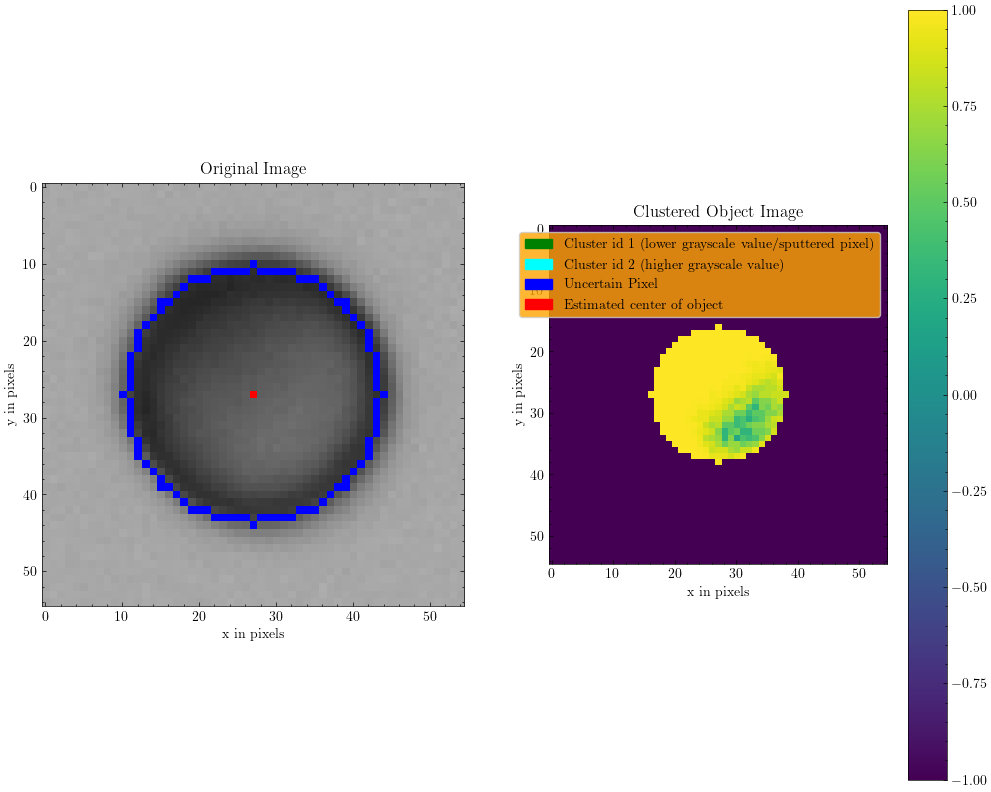

In [18]:
im_clustered=-np.ones(im_obj.shape,np.float32)
im_clustered[M==1]=prob[:,0]


im_bgr=cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR)
center=((im_bgr.shape[0]-1)//2, (im_bgr.shape[0]-1)//2)
im_bgr[center[0],center[0],:]=np.array([255,0,0])
cv.circle(im_bgr, center, round(r), (0,0,255), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Original Image")
    ax1.imshow(im_bgr,cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    a=ax2.imshow(im_clustered,cmap="viridis",vmin=-1,vmax=1)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    blue_patch = mpatches.Patch(color='blue', label='Uncertain Pixel')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax2.legend(handles=[green_patch, cyan_patch, blue_patch, red_patch],frameon=True, facecolor="orange")
    fig.colorbar(a, ax=ax2,location='right')
    plt.show()

# Angles and Magnitude 

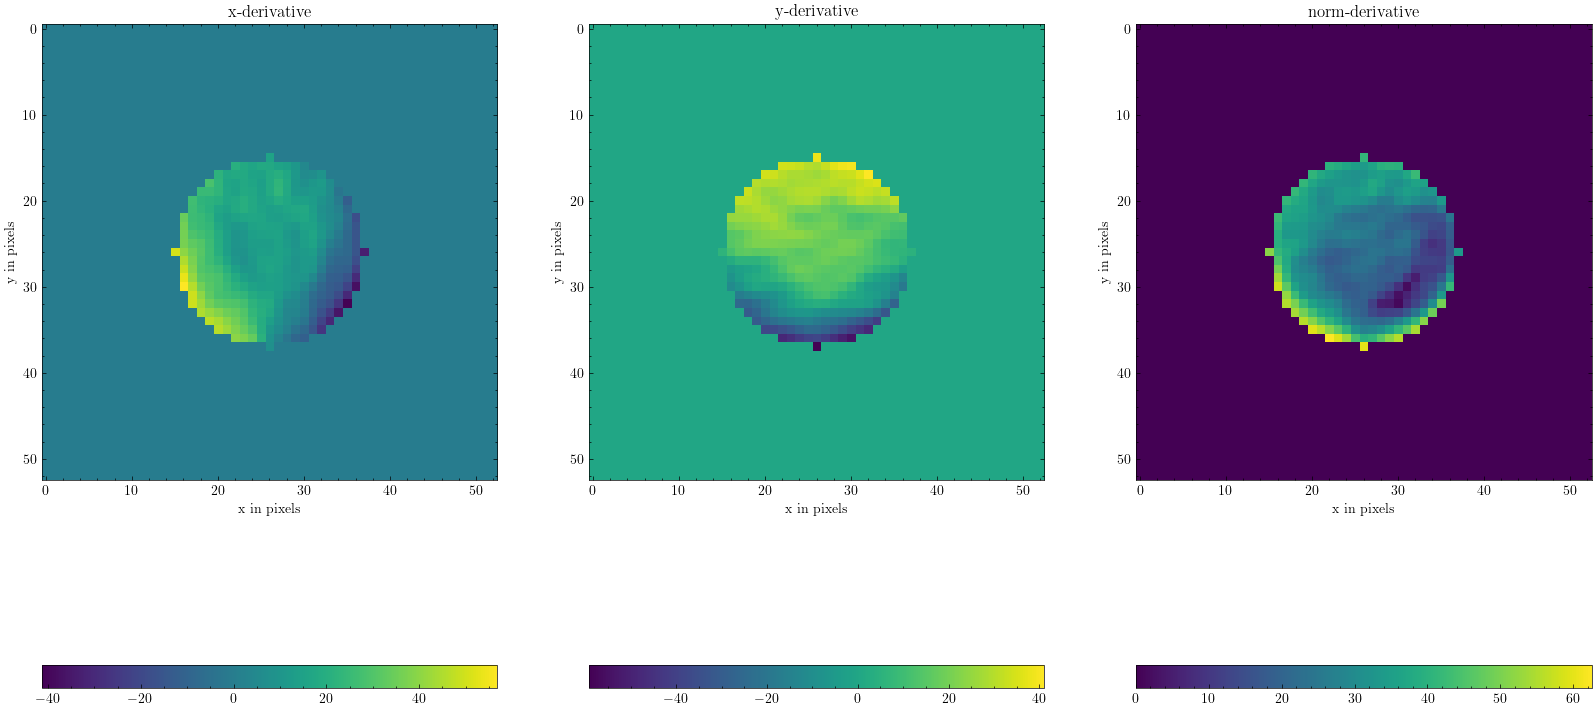

In [19]:
im_obj_blurred=im_obj.astype(np.float32)
im_obj_blurred=cv.GaussianBlur(im_obj_blurred, ksize=(3,3), sigmaX=1)


Ix=ndimage.sobel(im_obj_blurred, 1, mode="constant") 
Ix[M==0]=0
Ix=Ix[1:-1,1:-1]
Iy=ndimage.sobel(im_obj_blurred, 0, mode="constant")
Iy[M==0]=0
Iy=Iy[1:-1,1:-1]
I_theta = np.arctan2(Iy, Ix)
I_norm=np.sqrt(Ix**2+Iy**2)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.set_title("x-derivative")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    a=ax1.imshow(Ix)
    fig.colorbar(a,location="bottom")
    ax2.set_title("y-derivative")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    a=ax2.imshow(Iy)
    fig.colorbar(a,location="bottom")
    ax3.set_title("norm-derivative")
    ax3.set_xlabel("x in pixels")
    ax3.set_ylabel("y in pixels")
    a=ax3.imshow(I_norm)
    fig.colorbar(a,location="bottom")
    plt.show()


# get pixels with cluster ids

In [20]:
im_clustered=np.zeros_like(im_obj)
im_clustered[M==1]=label_thresh
sputtered=np.argwhere(im_clustered==1)
sputtered[:,[0, 1]]=sputtered[:,[1, 0]]
unsputtered=np.argwhere(im_clustered==2)
unsputtered[:,[0, 1]]=unsputtered[:, [1, 0]]
uncertain=np.argwhere(im_clustered==3)
uncertain[:,[0, 1]]=uncertain[:, [1, 0]]



# looking at certain pixel

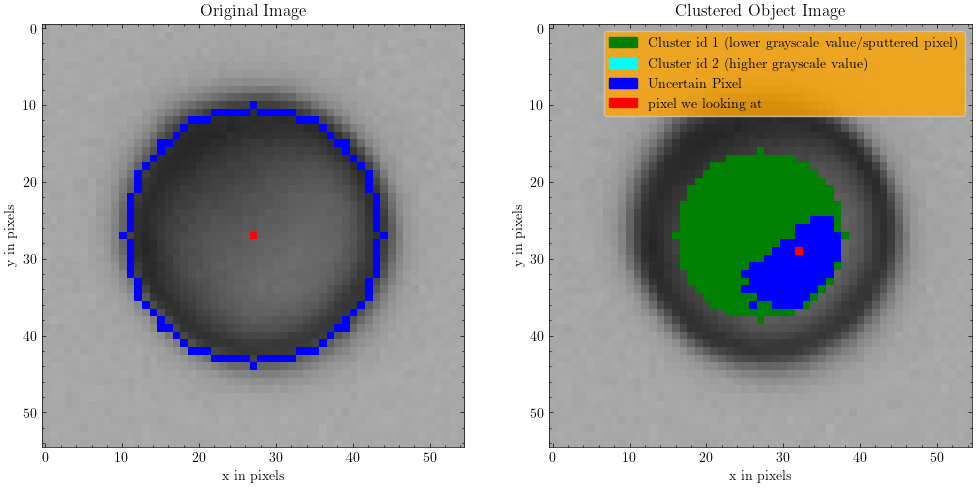

In [21]:
im_clustered=np.zeros(im_obj.shape,np.uint8)
im_clustered[M==1]=label_thresh
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)
a3=(im_clustered==3).reshape(-1)

im_clustered=np.copy(cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR))
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=green_vector
b=np.arange(a2.size)
c=b[a2]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=cyan_vector
b=np.arange(a3.size)
c=b[a3]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=blue_vector

im_clustered[uncertain[25,1],uncertain[25,0],:]=red_vector

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Original Image")
    ax1.imshow(im_bgr,cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    ax2.imshow(im_clustered)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    blue_patch = mpatches.Patch(color='blue', label='Uncertain Pixel')
    red_patch = mpatches.Patch(color='red', label='pixel we looking at')
    ax2.legend(handles=[green_patch, cyan_patch, blue_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()

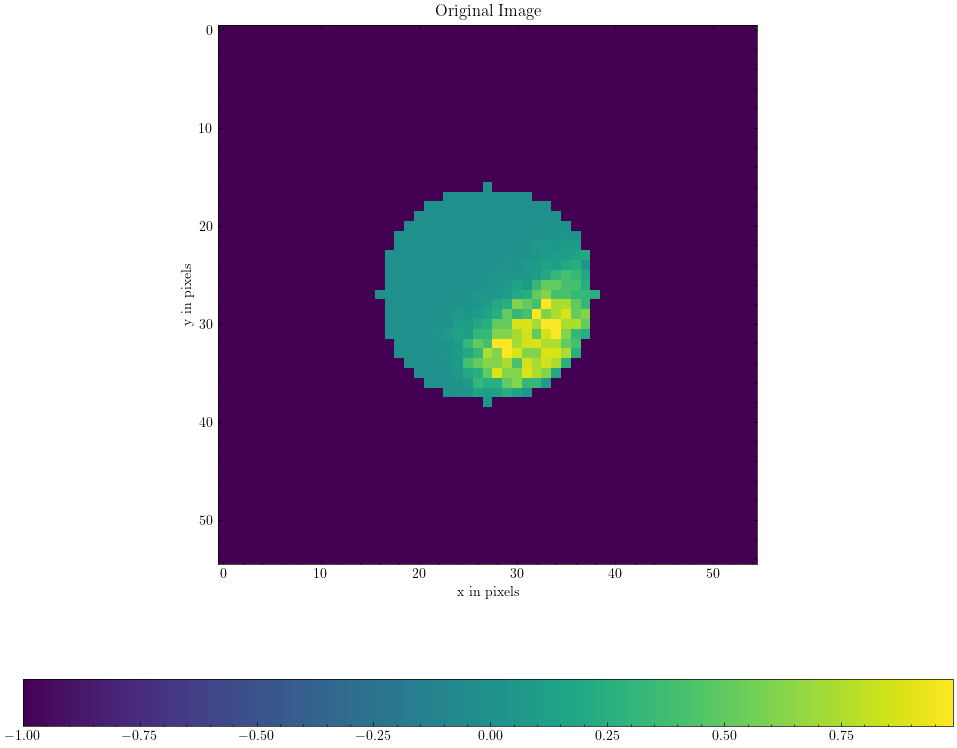

In [22]:
prob_matrix=-np.ones(im_obj.shape,np.float32)
prob_matrix[M==1]=prob[:,0]
prob_matrix[M==1]=1-2*np.abs(0.5-prob_matrix[M==1])
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1) = plt.subplots(1,1)
    ax1.set_title("Original Image")
    a=ax1.imshow(prob_matrix)
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    blue_patch = mpatches.Patch(color='blue', label='Uncertain Pixel')
    red_patch = mpatches.Patch(color='red', label='pixel we looking at')
    fig.colorbar(a,location="bottom")
    plt.show()


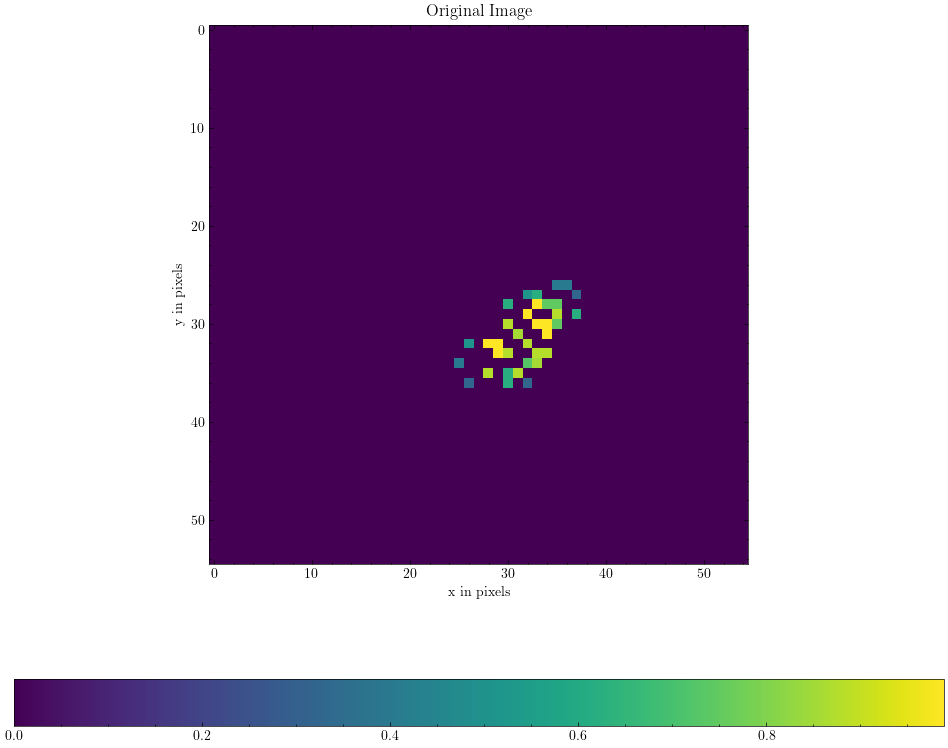

In [23]:
out=non_max_suppression(prob_matrix, I_theta)
M=np.zeros(out.shape,dtype=np.bool_)
M[uncertain[:,1],uncertain[:,0]]=1
out[M!=1]=0
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1) = plt.subplots(1,1)
    ax1.set_title("Original Image")
    a=ax1.imshow(out)
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    blue_patch = mpatches.Patch(color='blue', label='Uncertain Pixel')
    red_patch = mpatches.Patch(color='red', label='pixel we looking at')
    fig.colorbar(a,location="bottom")
    plt.show()
